<a href="https://colab.research.google.com/github/eckatherina/simpsons-classification/blob/main/my_simpsons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from torchvision import transforms

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


import numpy as np
import pandas as pd
import seaborn as sns
import torch

In [ ]:
np.random.seed(22)
torch.manual_seed(22)
torch.cuda.manual_seed(22)
torch.backends.cudnn.deterministic = True

In [ ]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sun Nov 20 16:04:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [ ]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
train_labels = [path.parent.name for path in train_val_files]
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Давайте посмотрим на наших героев внутри датасета.

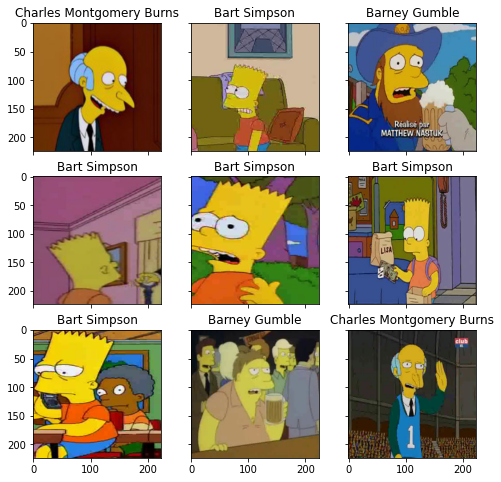

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [ ]:
data = pd.Series(train_labels).value_counts().sort_values().to_frame("count")
data

,count
lionel_hutz,3
troy_mcclure,8
disco_stu,8
miss_hoover,17
gil,27
fat_tony,27
otto_mann,32
sideshow_mel,40
agnes_skinner,42
rainier_wolfcastle,45


данные не сбалансированы!!!

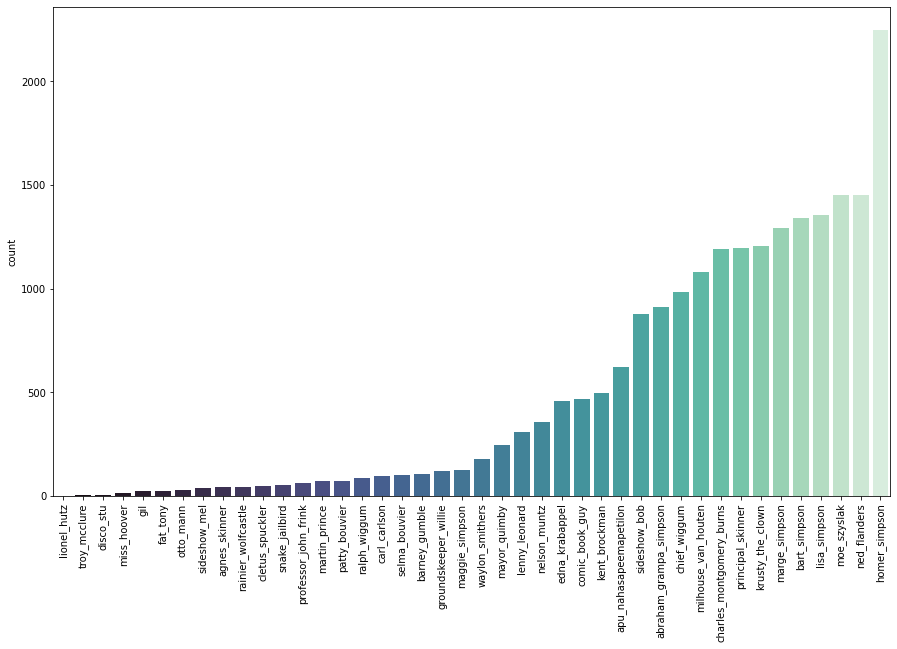

In [ ]:
plt.figure(figsize=(15, 9))
sns.barplot(x=data.index, y=data['count'], orient='v', palette = 'mako').set_xticklabels(data.index, rotation=90)
plt.show()

капец

### Аугментация

In [ ]:
augmenters = {
    'Crop': transforms.Compose([
                                transforms.Resize(size=300, max_size=301),
                                transforms.CenterCrop(size=300),
                                transforms.RandomCrop(250)
                                ]),
    'Rotate': transforms.RandomRotation(degrees=(-25, 25)),
    'HFlip': transforms.RandomHorizontalFlip(p=1)
}

In [ ]:
def load_image(file):
    image = Image.open(file)
    image.load()
    return image

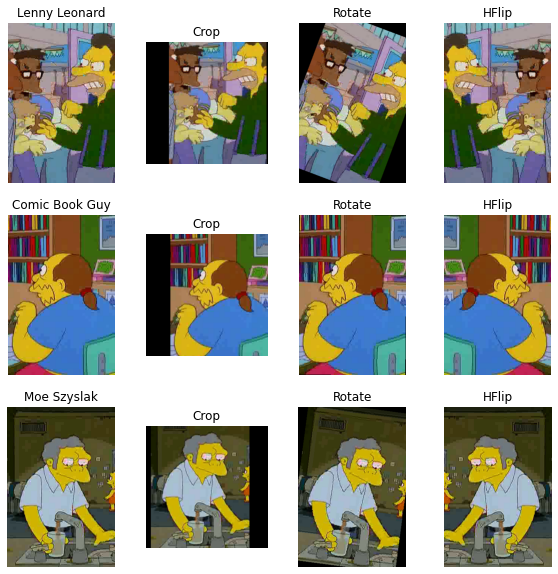

In [ ]:
n_examples = 3

fig, ax = plt.subplots(nrows=n_examples, ncols=(len(augmenters) + 1),figsize=(10, 10))

for i in range(n_examples):
    random_character = int(np.random.uniform(0, len(train_val_files)))
    img_orig = load_image(train_val_files[random_character])
    img_label = train_val_files[random_character].parent.name

    img_label = " ".join(map(lambda x: x.capitalize(),\
                img_label.split('_')))
    ax[i][0].imshow(img_orig)
    ax[i][0].set_title(img_label)
    ax[i][0].axis('off')
        
    for j, (augmenter_name, augmenter) in enumerate(augmenters.items()):
        img_aug = augmenter(img_orig)
        ax[i][j + 1].imshow(img_aug)
        ax[i][j + 1].set_title(augmenter_name)
        ax[i][j + 1].axis('off')

In [ ]:
def get_count(labels):
    df = pd.DataFrame(labels, columns=['name'])
    df['count'] = 1
    return df.groupby('name').count().sort_values('count')

In [ ]:
data = get_count(train_val_labels)

In [ ]:
import math

In [ ]:
data['to_add'] = data['count'].apply(lambda x: 200 - x if x < 200 else 0)
data['one_iteration'] = data.apply(lambda x: math.ceil(x['to_add'] / x['count']), axis=1)
data

,count,to_add,one_iteration
name,,,
lionel_hutz,3,197,66
disco_stu,8,192,24
troy_mcclure,8,192,24
miss_hoover,17,183,11
fat_tony,27,173,7
gil,27,173,7
otto_mann,32,168,6
sideshow_mel,40,160,4
agnes_skinner,42,158,4


In [ ]:
import random

In [ ]:
for image_path in tqdm(train_val_files):
    path = image_path.parents[0]
    character = image_path.parent.name
    img = load_image(image_path)
    # if we don't need to add any images, we can continue without transformation
    if data.loc[character]['to_add'] <= 0:
        continue

    # if number of images to create for one iteration is greater than the rest of images to create,
    # we should use 'to_add' instead of 'one_iteration'  
    if data.loc[character]['one_iteration'] > data.loc[character]['to_add']:
        iter_size = data.loc[character]['to_add']
    else:
        iter_size = data.loc[character]['one_iteration']
    data.loc[character]['to_add'] -= iter_size
    
    for i in range(iter_size):
        augmenter = random.choice(list(augmenters.values()))
        aug_img = augmenter(img)
        aug_img.save(f"{path}/{image_path.name.split('.')[0]}_{i}.jpg")


100%|██████████| 20933/20933 [01:10<00:00, 295.44it/s]


In [ ]:
aug_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
aug_labels = [path.parent.name for path in aug_files]
aug_data = get_count(aug_labels)

In [ ]:
def show_data(data):
  plt.figure(figsize=(15, 9))
  sns.barplot(x=data.index, y=data['count'], orient='v', palette = 'mako').set_xticklabels(data.index, rotation=90)
  plt.show()

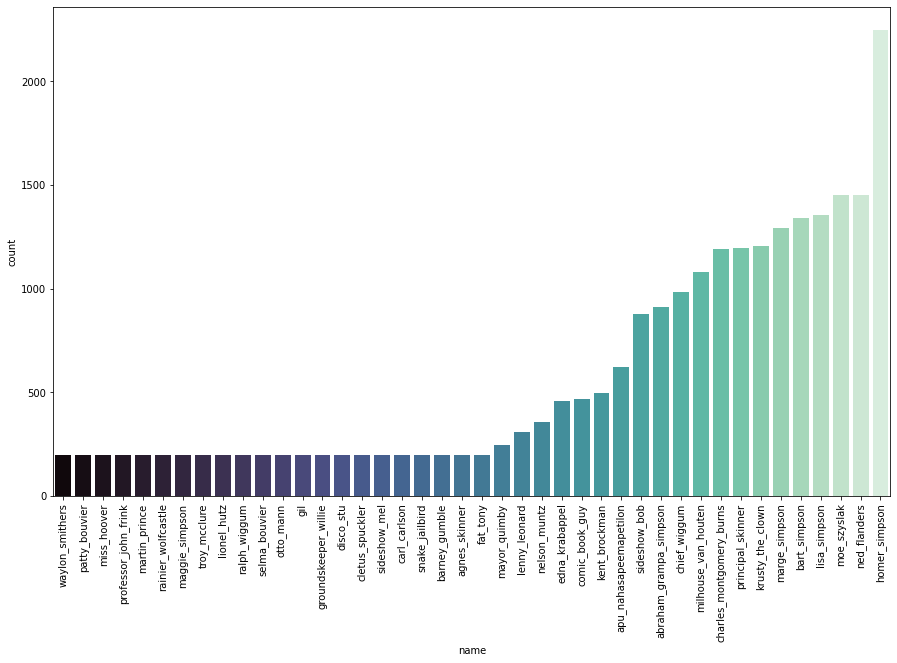

In [ ]:
show_data(aug_data)

теперь кул

In [ ]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
train_labels = [path.parent.name for path in train_val_files]
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

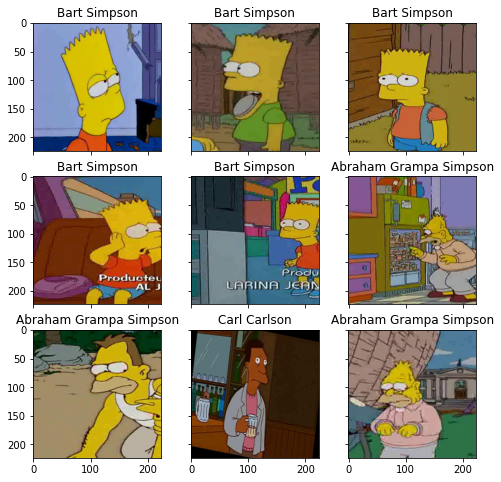

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [ ]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

NameError: ignored

Запустим обучение сети.

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=15, batch_size=64)

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

loss 2.439413888696364


epoch:   7%|▋         | 1/15 [02:27<34:18, 147.02s/it]


Epoch 001 train_loss: 2.4394     val_loss 1.8548 train_acc 0.3255 val_acc 0.4939
loss 1.4426509686750746


epoch:  13%|█▎        | 2/15 [05:05<33:19, 153.79s/it]


Epoch 002 train_loss: 1.4427     val_loss 1.2237 train_acc 0.6084 val_acc 0.6815
loss 0.9814182448724295


epoch:  20%|██        | 3/15 [07:44<31:15, 156.31s/it]


Epoch 003 train_loss: 0.9814     val_loss 1.1011 train_acc 0.7295 val_acc 0.7146
loss 0.716554585141174


epoch:  27%|██▋       | 4/15 [10:17<28:25, 155.01s/it]


Epoch 004 train_loss: 0.7166     val_loss 0.9707 train_acc 0.7979 val_acc 0.7430
loss 0.5266027310671522


epoch:  33%|███▎      | 5/15 [12:43<25:14, 151.45s/it]


Epoch 005 train_loss: 0.5266     val_loss 0.8943 train_acc 0.8501 val_acc 0.7818
loss 0.3903884221599454


epoch:  40%|████      | 6/15 [15:10<22:30, 150.04s/it]


Epoch 006 train_loss: 0.3904     val_loss 0.9087 train_acc 0.8852 val_acc 0.7923
loss 0.2789035036631227


epoch:  47%|████▋     | 7/15 [17:41<20:03, 150.44s/it]


Epoch 007 train_loss: 0.2789     val_loss 0.9632 train_acc 0.9183 val_acc 0.7839
loss 0.21147432736993116


epoch:  53%|█████▎    | 8/15 [20:39<18:33, 159.07s/it]


Epoch 008 train_loss: 0.2115     val_loss 1.0183 train_acc 0.9345 val_acc 0.8011
loss 0.156730755860809


epoch:  60%|██████    | 9/15 [23:24<16:06, 161.16s/it]


Epoch 009 train_loss: 0.1567     val_loss 1.1518 train_acc 0.9506 val_acc 0.7971
loss 0.13816988192528584


epoch:  67%|██████▋   | 10/15 [26:00<13:17, 159.41s/it]


Epoch 010 train_loss: 0.1382     val_loss 1.2567 train_acc 0.9553 val_acc 0.7988
loss 0.12268367290109561


epoch:  73%|███████▎  | 11/15 [28:34<10:30, 157.72s/it]


Epoch 011 train_loss: 0.1227     val_loss 1.3673 train_acc 0.9594 val_acc 0.7952
loss 0.09920028909776034


epoch:  80%|████████  | 12/15 [31:10<07:52, 157.40s/it]


Epoch 012 train_loss: 0.0992     val_loss 1.3108 train_acc 0.9679 val_acc 0.8057
loss 0.07603208595297505


epoch:  87%|████████▋ | 13/15 [33:41<05:10, 155.32s/it]


Epoch 013 train_loss: 0.0760     val_loss 1.4902 train_acc 0.9755 val_acc 0.7940
loss 0.07823177009224853


epoch:  93%|█████████▎| 14/15 [36:04<02:31, 151.70s/it]


Epoch 014 train_loss: 0.0782     val_loss 1.5549 train_acc 0.9746 val_acc 0.8070
loss 0.06895966940275938


epoch: 100%|██████████| 15/15 [38:27<00:00, 153.85s/it]


Epoch 015 train_loss: 0.0690     val_loss 1.5223 train_acc 0.9781 val_acc 0.7874


Построим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

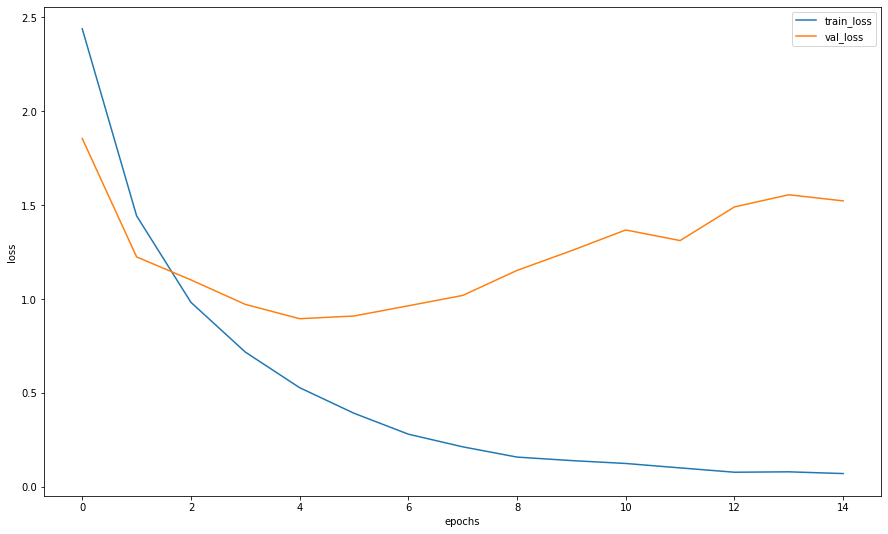

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

грустно

# Попробуем улучшить. Для начала добавим слои и/или изменим некоторые параметры в исходной модеди

In [ ]:
from torch.nn import functional as F


In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
n_classes = len(np.unique(train_labels))
model = nn.Sequential(
    nn.Sequential(
        nn.Conv2d(3, 8, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Sequential(
        nn.Conv2d(8, 16, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Sequential(
        nn.Conv2d(16, 32, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Flatten(),
    nn.Dropout(p=0.3),
    nn.Sequential(
      nn.Linear(in_features=3200, out_features=8192, bias=True),
           nn.ReLU(inplace=True),
        ),
    nn.Dropout(p=0.3),
        nn.Sequential(
            nn.Linear(in_features=8192, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
        ),
    nn.Linear(in_features=4096, out_features=n_classes, bias=True)
).to(DEVICE)


In [ ]:
def train1(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1e-3)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [ ]:
history = train1(train_dataset, val_dataset, model=model, epochs=10, batch_size=64)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 2.1357801586952037


epoch:  10%|█         | 1/10 [02:46<24:59, 166.66s/it]


Epoch 001 train_loss: 2.1358     val_loss 1.4716 train_acc 0.4054 val_acc 0.5838
loss 1.08075773766415


epoch:  20%|██        | 2/10 [05:30<21:59, 164.93s/it]


Epoch 002 train_loss: 1.0808     val_loss 0.9381 train_acc 0.6882 val_acc 0.7413
loss 0.5574450567178024


epoch:  30%|███       | 3/10 [08:14<19:10, 164.38s/it]


Epoch 003 train_loss: 0.5574     val_loss 0.7925 train_acc 0.8365 val_acc 0.7964
loss 0.25945437831095747


epoch:  40%|████      | 4/10 [10:58<16:25, 164.29s/it]


Epoch 004 train_loss: 0.2595     val_loss 0.7461 train_acc 0.9212 val_acc 0.8208
loss 0.15583814103976634


epoch:  50%|█████     | 5/10 [13:44<13:44, 164.97s/it]


Epoch 005 train_loss: 0.1558     val_loss 0.7822 train_acc 0.9522 val_acc 0.8305
loss 0.09466379501096032


epoch:  60%|██████    | 6/10 [16:32<11:03, 165.91s/it]


Epoch 006 train_loss: 0.0947     val_loss 0.8130 train_acc 0.9724 val_acc 0.8315
loss 0.07231988058296425


epoch:  70%|███████   | 7/10 [19:25<08:25, 168.38s/it]


Epoch 007 train_loss: 0.0723     val_loss 0.8215 train_acc 0.9791 val_acc 0.8376
loss 0.07284479131470491


epoch:  80%|████████  | 8/10 [22:11<05:35, 167.68s/it]


Epoch 008 train_loss: 0.0728     val_loss 0.9783 train_acc 0.9795 val_acc 0.8188
loss 0.04680067963958746


epoch:  90%|█████████ | 9/10 [25:06<02:49, 169.97s/it]


Epoch 009 train_loss: 0.0468     val_loss 0.8872 train_acc 0.9869 val_acc 0.8393
loss 0.047908616721093734


epoch: 100%|██████████| 10/10 [28:06<00:00, 168.64s/it]


Epoch 010 train_loss: 0.0479     val_loss 0.9662 train_acc 0.9867 val_acc 0.8320


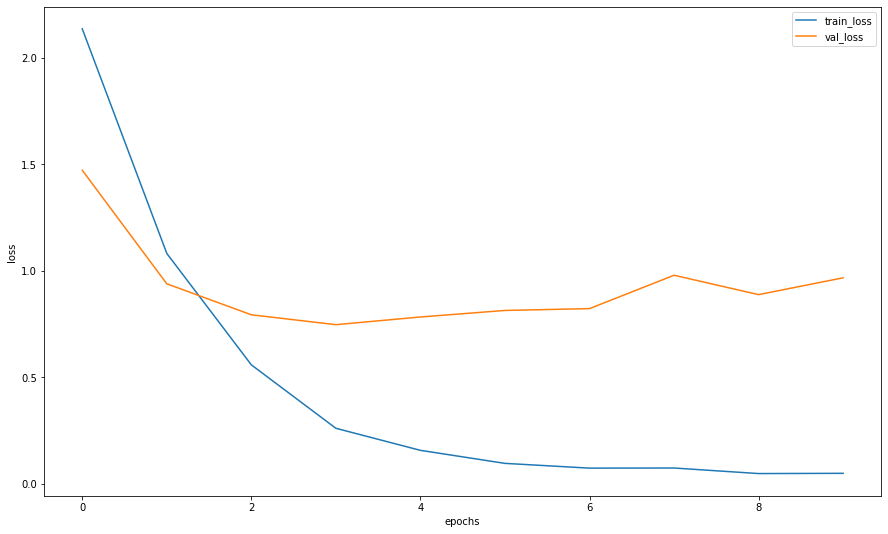

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Все еще не очень. Налицо переобучение.

### Работа с learning rate

In [ ]:
def fit_epoch2(model, train_loader, criterion, optimizer, learn):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    learn.step()      
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def train2(train_files, val_files, model, learn, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1e-3)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch2(model, train_loader, criterion, opt, learn)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [ ]:
class Cnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        
        self.fc1 = nn.Linear(128*5*5, 4096)  
        self.fc2 = nn.Linear(4096, 4096)
        
        self.out = nn.Linear(4096, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)


        x = nn.Flatten()(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        logits = self.out(x)
        return logits

In [ ]:
Cnn = Cnn(n_classes).to(DEVICE)
optimizer = torch.optim.Adam(Cnn.parameters(), amsgrad=True, lr=1e-3)
learn = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
history = train2(train_dataset, val_dataset, model=Cnn, learn = learn, epochs=10, batch_size=128)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 3.279708219871417


epoch:  10%|█         | 1/10 [02:43<24:27, 163.08s/it]


Epoch 001 train_loss: 3.2797     val_loss 2.6457 train_acc 0.1225 val_acc 0.2876
loss 2.013827141469136


epoch:  20%|██        | 2/10 [05:24<21:38, 162.37s/it]


Epoch 002 train_loss: 2.0138     val_loss 1.4978 train_acc 0.4390 val_acc 0.5879
loss 1.1322176748451456


epoch:  30%|███       | 3/10 [08:08<19:00, 162.98s/it]


Epoch 003 train_loss: 1.1322     val_loss 1.0510 train_acc 0.6751 val_acc 0.7049
loss 0.6621437739585225


epoch:  40%|████      | 4/10 [10:54<16:23, 163.95s/it]


Epoch 004 train_loss: 0.6621     val_loss 0.7709 train_acc 0.8058 val_acc 0.7914
loss 0.3635781295670147


epoch:  50%|█████     | 5/10 [13:38<13:40, 164.18s/it]


Epoch 005 train_loss: 0.3636     val_loss 0.7524 train_acc 0.8934 val_acc 0.8118
loss 0.19415016243193106


epoch:  60%|██████    | 6/10 [16:23<10:56, 164.24s/it]


Epoch 006 train_loss: 0.1942     val_loss 0.8343 train_acc 0.9400 val_acc 0.8159
loss 0.11538856870167957


epoch:  70%|███████   | 7/10 [19:07<08:12, 164.25s/it]


Epoch 007 train_loss: 0.1154     val_loss 0.7946 train_acc 0.9654 val_acc 0.8311
loss 0.08337617698424471


epoch:  80%|████████  | 8/10 [21:45<05:24, 162.29s/it]


Epoch 008 train_loss: 0.0834     val_loss 0.8350 train_acc 0.9743 val_acc 0.8361
loss 0.05498255058616129


epoch:  90%|█████████ | 9/10 [24:15<02:38, 158.44s/it]


Epoch 009 train_loss: 0.0550     val_loss 0.9764 train_acc 0.9842 val_acc 0.8315
loss 0.05268233783544562


epoch: 100%|██████████| 10/10 [26:45<00:00, 160.56s/it]


Epoch 010 train_loss: 0.0527     val_loss 0.8918 train_acc 0.9836 val_acc 0.8381


### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(Cnn, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(Cnn, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
#preds = [classes_[i] for i in y_pred]
y_pred

array([ 6, 20,  4,  0,  1,  4,  6,  0,  6,  0,  6,  0,  4,  6,  1,  0,  2,
        4,  2,  0])

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [ ]:
actual_labels

[6, 4, 4, 0, 1, 4, 6, 0, 6, 0, 6, 0, 4, 6, 1, 0, 2, 4, 2, 0]

In [ ]:
preds_class

['charles_montgomery_burns',
 'lisa_simpson',
 'bart_simpson',
 'abraham_grampa_simpson',
 'agnes_skinner',
 'bart_simpson',
 'charles_montgomery_burns',
 'abraham_grampa_simpson',
 'charles_montgomery_burns',
 'abraham_grampa_simpson',
 'charles_montgomery_burns',
 'abraham_grampa_simpson',
 'bart_simpson',
 'charles_montgomery_burns',
 'agnes_skinner',
 'abraham_grampa_simpson',
 'apu_nahasapeemapetilon',
 'bart_simpson',
 'apu_nahasapeemapetilon',
 'abraham_grampa_simpson']

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')


0.9500000000000001

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

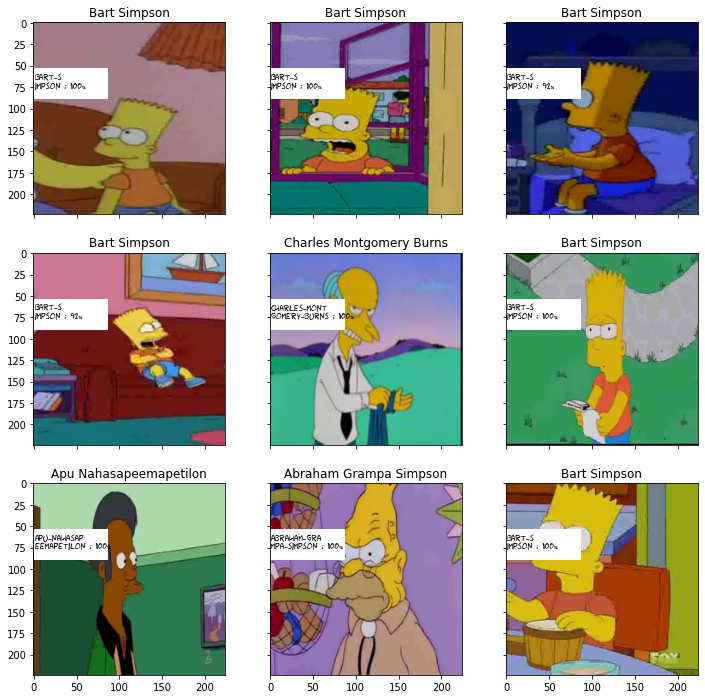

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(Cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(Cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
! ls 

characters_illustration.png  label_encoder.pkl	sample_submission.csv  train
gdrive			     sample_data	testset


In [ ]:
import pandas as pd
#my_submit = pd.read_csv("gdrive/My Drive/simpsons/data/labels.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [ ]:
my_submit.to_csv('gdrive/My Drive/simpsons.csv', index=False)

*Курсив*## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
